# Analyse des brevets de Wipo

In [19]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, to_date, year
from pyspark.sql.functions import split, array_distinct, concat_ws


spark = SparkSession.builder \
    .appName("wipo_patent") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0") \
    .getOrCreate()

mongo_ip = "mongodb://127.0.0.1:27017/"
db_name = "big_data_project" 
collection_name = "wipo_nv"  

df = spark.read.format("com.mongodb.spark.sql.DefaultSource") \
    .option("uri", "mongodb://127.0.0.1:27017/big_data_project.wipo_nv") \
    .load()


df.printSchema()


root
 |-- Abstract: string (nullable = true)
 |-- Abstract_english: string (nullable = true)
 |-- Agents: string (nullable = true)
 |-- Applicants: string (nullable = true)
 |-- Application_Date: timestamp (nullable = true)
 |-- English_Text: string (nullable = true)
 |-- Inventors: string (nullable = true)
 |-- Office: string (nullable = true)
 |-- Priority_Data: string (nullable = true)
 |-- Publication_Date: timestamp (nullable = true)
 |-- Publication_Kind: string (nullable = true)
 |-- Publication_Number: string (nullable = true)
 |-- Related_patent_documents: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- application_number: string (nullable = true)
 |-- link: string (nullable = true)



In [20]:
df.createOrReplaceTempView("patents_data")  
spark.sql("SELECT DISTINCT Publication_Kind FROM patents_data").show()

+----------------+
|Publication_Kind|
+----------------+
|              A2|
|              B2|
|               B|
|               C|
|              B1|
|              B3|
|               A|
|              A4|
|              A3|
|              A1|
|              B8|
|            NULL|
+----------------+



# Nombre de brevets par bureau

In [100]:
from pyspark.sql import functions as F

df.createOrReplaceTempView("patents_data")  
office_counts = spark.sql("""
    SELECT Office, COUNT(*) AS Occurrences
    FROM patents_data
    WHERE Office IS NOT NULL AND Office != 'NaN' 
    GROUP BY Office
    ORDER BY Occurrences DESC
""")

office_counts.show()

+--------------------+-----------+
|              Office|Occurrences|
+--------------------+-----------+
|              Canada|        211|
|              France|        191|
|European Patent O...|        147|
|               China|          1|
|               Japan|          1|
+--------------------+-----------+



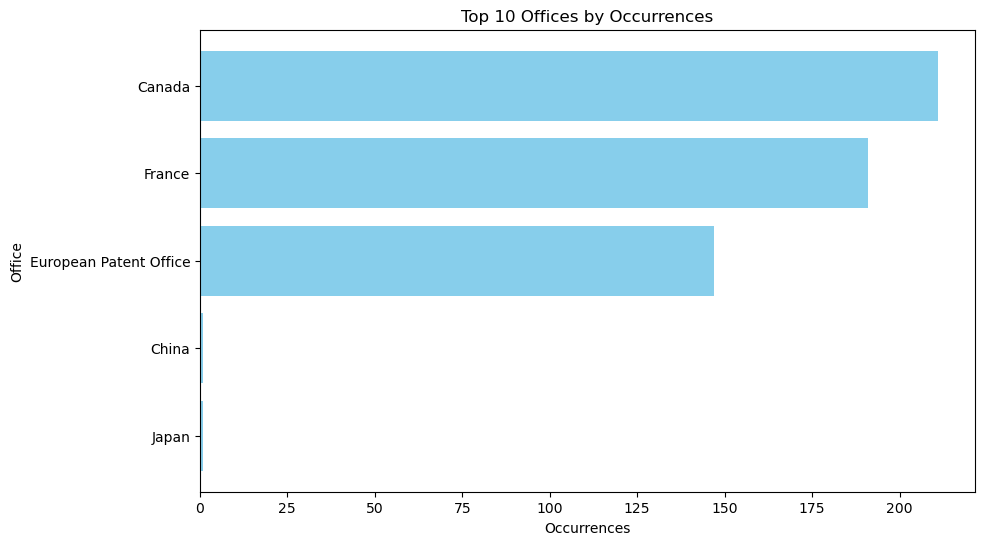

In [101]:
df_pd = office_counts.toPandas()

df_pd_top = df_pd.head(10)

plt.figure(figsize=(10, 6))
plt.barh(df_pd_top["Office"], df_pd_top["Occurrences"], color='skyblue')
plt.xlabel('Occurrences')
plt.ylabel('Office')
plt.title('Top 10 Offices by Occurrences')
plt.gca().invert_yaxis()  
plt.show()

# Nombre de brevets par type de publication

In [90]:
patents_by_publication_kind = df.groupBy("Publication_Kind").count().orderBy("count", ascending=False)
patents_by_publication_kind.show()


+----------------+-----+
|Publication_Kind|count|
+----------------+-----+
|              A1|  228|
|            NULL|  216|
|              B1|  193|
|               C|   79|
|              A3|   18|
|              A4|   17|
|               A|    8|
|              A2|    4|
|              B2|    1|
|               B|    1|
|              B3|    1|
|              B8|    1|
+----------------+-----+



# Nombre de brevets par demandeur

In [91]:
patents_by_applicant = df.groupBy("Applicants").count().orderBy("count", ascending=False)
patents_by_applicant.show()


+--------------------+-----+
|          Applicants|count|
+--------------------+-----+
|PEUGEOT CITROEN A...|   59|
|          RENAULT SA|   35|
|         RENAULT SAS|   33|
|                NULL|   22|
| BYD COMPANY LIMITED|   13|
|HONDA MOTOR CO., ...|   11|
|             RENAULT|   10|
|RENAULT S.A.S.\n\...|    9|
|MITSUBISHI ELECTR...|    9|
|   TAIGA MOTORS INC.|    8|
|RENAULT S.A.S\n\t...|    7|
|PSA AUTOMOBILES S...|    7|
|TOYOTA JIDOSHA KA...|    7|
|  NIKOLA CORPORATION|    6|
| TOYOTA MOTOR CO LTD|    6|
|KWANG YANG MOTOR ...|    6|
|  PSA AUTOMOBILES SA|    6|
|    SONY CORPORATION|    5|
|LOCKHEED MARTIN C...|    5|
|  HONDA MOTOR CO LTD|    5|
+--------------------+-----+
only showing top 20 rows



# Nombre de brevets par agent

In [92]:
patents_by_agent = df.groupBy("Agents").count().orderBy("count", ascending=False)
patents_by_agent.show()


+------------------------+-----+
|                  Agents|count|
+------------------------+-----+
|                    NULL|  597|
|          RENAULT S.A.S.|    7|
|         BONNIN, Patrick|    6|
|       ROSENBERG, Muriel|    5|
|         BONNET, Maïwenn|    4|
|        MENES, Catherine|    4|
|       BOURGUIGNON, Eric|    4|
|         CASALONGA, Axel|    4|
|          MORI, Masazumi|    4|
|    LEROUX, Jean-Phil...|    3|
|      SHIMOICHI, Tsutomu|    3|
|             DANG, Doris|    3|
|         MARTIN, Joaquim|    3|
|    RENAULT TECHNOCENTRE|    2|
|        Cabinet Chaillot|    2|
|                 AQUINOV|    2|
|岩橋 文雄 IWAHASHI, F...|    2|
|          ROULIN, Arnaud|    2|
|    METMAN, Karel, Jo...|    1|
| 박병창 PARK, Byung C...|    1|
+------------------------+-----+
only showing top 20 rows



In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F

result = spark.sql("""
    SELECT 
        CASE 
            WHEN Publication_Kind LIKE 'A%' THEN 'A%'
            WHEN Publication_Kind LIKE 'B%' THEN 'B%'
            WHEN Publication_Kind LIKE 'C%' THEN 'C%'
            ELSE 'NAN'
        END AS Publication_Group,
        COUNT(*) AS Count
    FROM patents_data 
    GROUP BY 
        CASE 
            WHEN Publication_Kind LIKE 'A%' THEN 'A%'
            WHEN Publication_Kind LIKE 'B%' THEN 'B%'
            WHEN Publication_Kind LIKE 'C%' THEN 'C%'
            ELSE 'NAN'
        END
""")

result.show()



+-----------------+-----+
|Publication_Group|Count|
+-----------------+-----+
|               B%|  197|
|               C%|   79|
|              NAN|  216|
|               A%|  275|
+-----------------+-----+



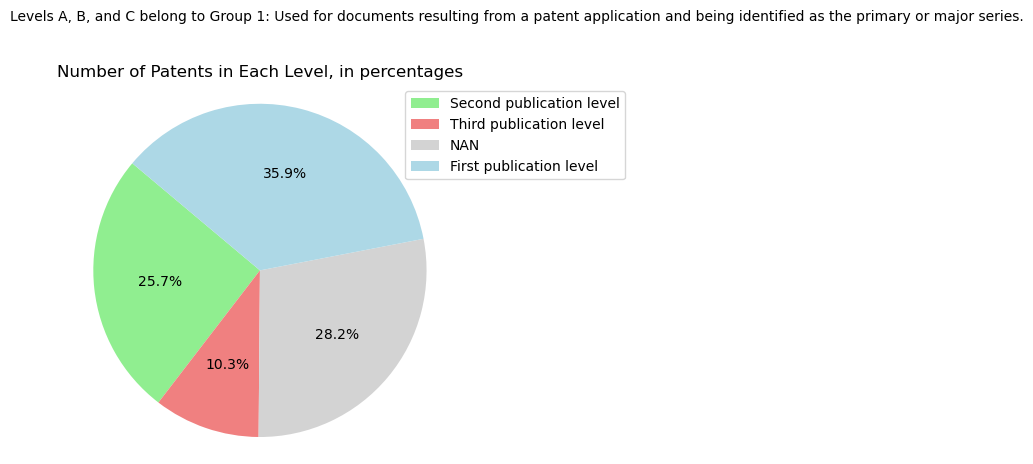

In [22]:
df_P = result.toPandas()
colors = {'A%': 'lightblue', 'B%': 'lightgreen', 'C%': 'lightcoral', 'NAN': 'lightgray'}

plt.pie(df_P["Count"], labels=None, colors=[colors[group] for group in df_P["Publication_Group"]], autopct='%1.1f%%', startangle=140)

plt.legend(labels=['Second publication level', 'Third publication level', 'NAN', 'First publication level'], loc='upper right', bbox_to_anchor=(1.25, 1))

plt.title("Number of Patents in Each Level, in percentages")

plt.text(-1.5, 1.5, "Levels A, B, and C belong to Group 1: Used for documents resulting from a patent application and being identified as the primary or major series.", fontsize=10, wrap=True)

plt.axis('equal')  
plt.show()

## Analyse des Inventeurs les Plus Fréquents 

In [23]:

from pyspark.sql import functions as F


inventor_counts = spark.sql("""
    SELECT Inventors, COUNT(*) AS Occurrences
    FROM patents_data
    WHERE Inventors IS NOT NULL AND Inventors != 'NaN'  -- Exclure les valeurs NaN
    GROUP BY Inventors
    ORDER BY Occurrences DESC
""")

inventor_counts.show(5)


+--------------------+-----------+
|           Inventors|Occurrences|
+--------------------+-----------+
|    PORCELLATO DENIS|          7|
|BERTRAND BELANGER...|          5|
|     GRIVAUX ANTOINE|          4|
|SUN, HUAJUNWANG, ...|          3|
|LACROIX, Eric\n\t...|          3|
+--------------------+-----------+
only showing top 5 rows



In [26]:
df_pd = df.toPandas()

In [27]:
df_pd['English_Text'] = df_pd['English_Text'].str.replace(r'\(EN\)', '', regex=True)

df_pd['English_Text'] = df_pd['English_Text'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

In [28]:
df_pd['Abstract_english'] = df_pd['Abstract_english'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

In [29]:
df_pd['Abstract_english'] = df_pd['Abstract_english'].str.lower()
df_pd['English_Text'] = df_pd['English_Text'].str.lower()

In [30]:
df_pd.head(2)

,Abstract,Abstract_english,Agents,Applicants,Application_Date,English_Text,Inventors,Office,Priority_Data,Publication_Date,Publication_Kind,Publication_Number,Related_patent_documents,Title,_id,application_number,link
0,(EN) A battery system for an electric vehicle ...,a battery system for an electric vehicle inclu...,None,HEXAGON PURUS NORTH AMERICA HOLDINGS INC.,2022-08-19,battery packs for utility vehicle electric dr...,"TYERMAN, LANDONCOUPAL-SIKES, ERIC M.",Canada,"63/260,613 26.08.2021 US",2023-03-02,A1,3227982,['https://patentscope.wipo.int/search/en/detai...,(EN) BATTERY PACKS FOR UTILITY VEHICLE ELECTRI...,"(662e623e75df7407000dca58,)",3227982.0,https://patentscope.wipo.int/search/en/detail....
1,(EN) An electric vehicle may include a first d...,an electric vehicle may include a first drive ...,None,"ZHAO, DEZHOU DAVID",2014-10-22,electric vehicle control system and drive app...,"ZHAO, DEZHOU DAVID",Canada,14061016 23.10.2013 US,2015-04-30,C,2925742,['https://patentscope.wipo.int/search/en/detai...,(EN) ELECTRIC VEHICLE CONTROL SYSTEM AND DRIVE...,"(662e623e75df7407000dca59,)",2925742.0,https://patentscope.wipo.int/search/en/detail....


In [31]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to C:\Users\HP 840
[nltk_data]     G3\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\HP 840
[nltk_data]     G3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

def process_abstract(abstract):
    tokens = word_tokenize(abstract)
    tokens = [word for word in tokens if word not in string.punctuation]
    stop_words_en = set(stopwords.words('english'))
    stop_words_fr = set(stopwords.words('french'))
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words_en and word.lower() not in stop_words_fr]
    return tokens

df_pd['abstract_tokens'] = df_pd['Abstract_english'].apply(process_abstract)
df_pd['Title_tokens'] = df_pd['English_Text'].apply(process_abstract)

In [51]:
df_pd = df_pd.drop('abstract_tokens', axis=1)
df_pd = df_pd.drop('Title_tokens', axis=1)

In [54]:
df_pd.head(2)

,Abstract,Abstract_english,Agents,Applicants,Application_Date,English_Text,Inventors,Office,Priority_Data,Publication_Date,Publication_Kind,Publication_Number,Related_patent_documents,Title,_id,application_number,link,abstract_tokens,Title_tokens
0,(EN) A battery system for an electric vehicle ...,a battery system for an electric vehicle inclu...,None,HEXAGON PURUS NORTH AMERICA HOLDINGS INC.,2022-08-19,battery packs for utility vehicle electric dr...,"TYERMAN, LANDONCOUPAL-SIKES, ERIC M.",Canada,"63/260,613 26.08.2021 US",2023-03-02,A1,3227982,['https://patentscope.wipo.int/search/en/detai...,(EN) BATTERY PACKS FOR UTILITY VEHICLE ELECTRI...,"(662e623e75df7407000dca58,)",3227982.0,https://patentscope.wipo.int/search/en/detail....,"[battery, system, electric, vehicle, includes,...","[battery, packs, utility, vehicle, electric, d..."
1,(EN) An electric vehicle may include a first d...,an electric vehicle may include a first drive ...,None,"ZHAO, DEZHOU DAVID",2014-10-22,electric vehicle control system and drive app...,"ZHAO, DEZHOU DAVID",Canada,14061016 23.10.2013 US,2015-04-30,C,2925742,['https://patentscope.wipo.int/search/en/detai...,(EN) ELECTRIC VEHICLE CONTROL SYSTEM AND DRIVE...,"(662e623e75df7407000dca59,)",2925742.0,https://patentscope.wipo.int/search/en/detail....,"[electric, vehicle, may, include, first, drive...","[electric, vehicle, control, system, drive, ap..."


In [55]:
from collections import Counter

all_words_abs = [word for sublist in df_pd["abstract_tokens"] for word in sublist]
all_words_tit = [word for sublist in df_pd["Title_tokens"] for word in sublist]
abstract_word_counts = Counter(all_words_abs)
title_word_counts = Counter(all_words_tit)


In [56]:
print(abstract_word_counts.most_common(10))
print(title_word_counts.most_common(10))

[('battery', 2505), ('batterie', 1780), ('electric', 1674), ('vehicle', 1651), ('lectrique', 1546), ('vhicule', 1449), ('power', 1046), ('charge', 860), ('moteur', 780), ('motor', 770)]
[('vehicule', 774), ('electric', 685), ('vehicle', 555), ('electrique', 531), ('battery', 495), ('vehiclefr', 304), ('batterie', 279), ('dun', 268), ('hybrid', 207), ('system', 205)]


## Word cloud des mots dans les titres

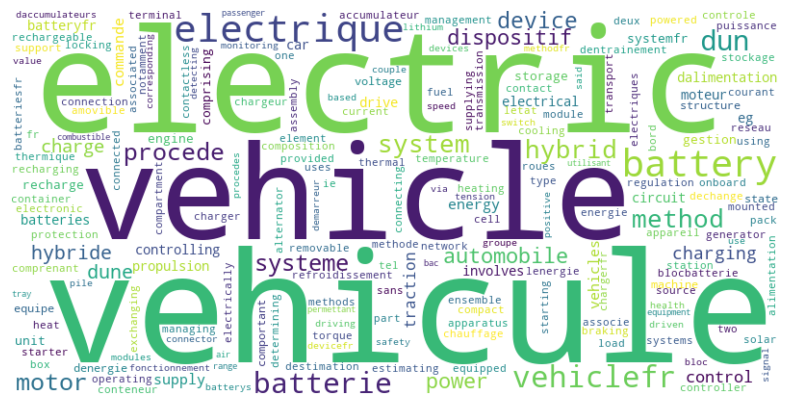

In [59]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(title_word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Word cloud des mots dans les résumés

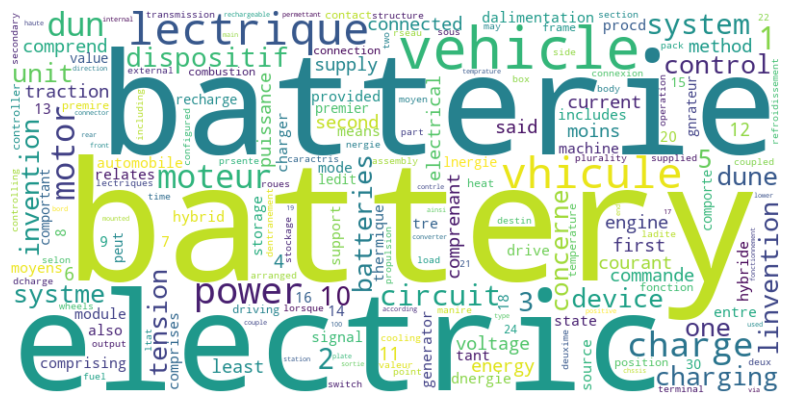

In [60]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(abstract_word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Regrouper les mots des résumés en clusters selon les années d'apparition

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd

df_pd['Publication_Date'] = pd.to_datetime(df_pd['Publication_Date'])

df_pd['abstract_text'] = df_pd['abstract_tokens'].apply(lambda tokens: ' '.join(tokens))

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_pd['abstract_text'])

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

df_pd['Cluster_label'] = kmeans.labels_


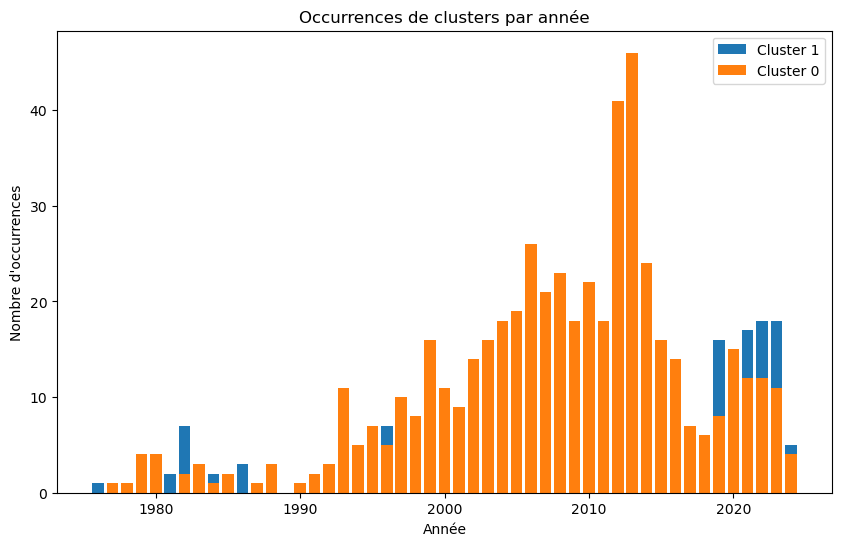

In [66]:
clusters_by_year = df_pd.groupby([df_pd['Publication_Date'].dt.year, 'Cluster_label']).size()
clusters_by_year = clusters_by_year.reset_index(name='Count')

plt.figure(figsize=(10, 6))
for cluster_label in clusters_by_year['Cluster_label'].unique():
    cluster_data = clusters_by_year[clusters_by_year['Cluster_label'] == cluster_label]
    plt.bar(cluster_data['Publication_Date'], cluster_data['Count'], label=f'Cluster {cluster_label}')

plt.xlabel('Année')
plt.ylabel('Nombre d\'occurrences')
plt.title('Occurrences de clusters par année')
plt.legend()
plt.show()


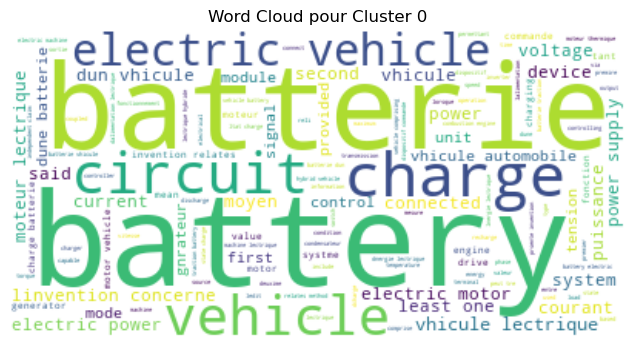

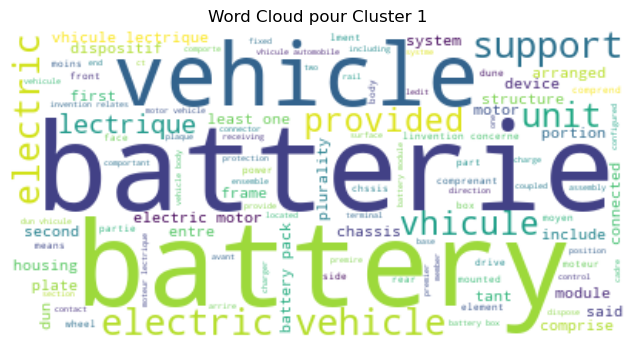

In [67]:
tokens_by_cluster = df_pd.groupby('Cluster_label')['abstract_text'].apply(lambda x: ' '.join(x))

for cluster_label, text in tokens_by_cluster.items():
    wordcloud = WordCloud(background_color='white').generate(text)
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud pour Cluster {cluster_label}')
    plt.axis('off')
    plt.show()

## Regrouper les mots des titres en clusters selon les années d'apparition

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd

df_pd['Publication_Date'] = pd.to_datetime(df_pd['Publication_Date'])

df_pd['title_text'] = df_pd['Title_tokens'].apply(lambda tokens: ' '.join(tokens))

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_pd['title_text'])

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

df_pd['Cluster_label_title'] = kmeans.labels_


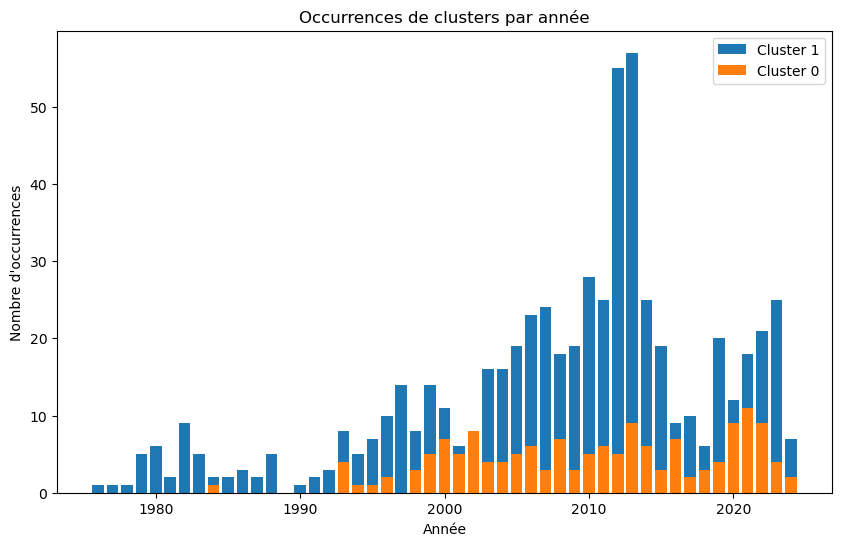

In [71]:

clusters_by_year = df_pd.groupby([df_pd['Publication_Date'].dt.year, 'Cluster_label_title']).size()

clusters_by_year = clusters_by_year.reset_index(name='Count')

plt.figure(figsize=(10, 6))
for cluster_label in clusters_by_year['Cluster_label_title'].unique():
    cluster_data = clusters_by_year[clusters_by_year['Cluster_label_title'] == cluster_label]
    plt.bar(cluster_data['Publication_Date'], cluster_data['Count'], label=f'Cluster {cluster_label}')

plt.xlabel('Année')
plt.ylabel('Nombre d\'occurrences')
plt.title('Occurrences de clusters par année')
plt.legend()
plt.show()


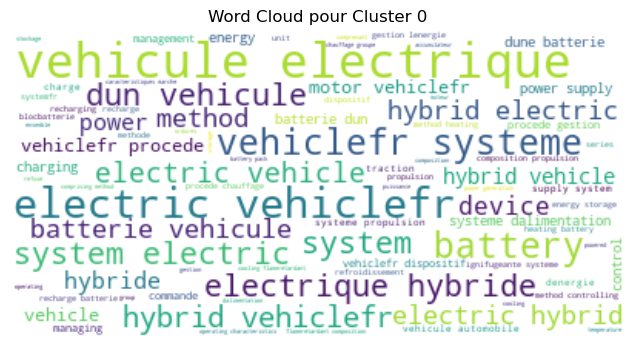

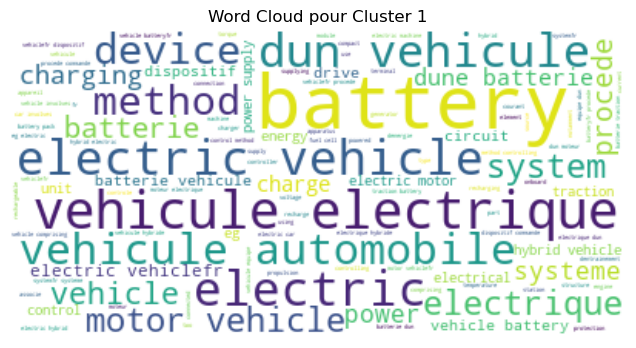

In [72]:
tokens_by_cluster = df_pd.groupby('Cluster_label_title')['title_text'].apply(lambda x: ' '.join(x))

for cluster_label, text in tokens_by_cluster.items():
    wordcloud = WordCloud(background_color='white').generate(text)
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud pour Cluster {cluster_label}')
    plt.axis('off')
    plt.show()